In [ ]:
## library import
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import re
from PIL import Image
import shutil
import random
import matplotlib.pyplot as plt

print(tf.__version__)
print(keras.__version__)

2.2.0
2.3.0-tf


## Data 준비하기

In [ ]:
## google drive에서 압축된 dataset download
import gdown
url = 'https://drive.google.com/uc?id=1dIR9ANjUsV9dWa0pS9J0c2KUGMfpIRG0'
fname = 'oxford_pet.zip'
gdown.download(url, fname, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1dIR9ANjUsV9dWa0pS9J0c2KUGMfpIRG0
To: /content/oxford_pet.zip
811MB [00:06, 134MB/s]


'oxford_pet.zip'

In [ ]:
## oxford_pet.zip이 보이는지 확인
!ls -l

total 791576
-rw-r--r-- 1 root root 810565619 Jul 17 13:26 oxford_pet.zip
drwxr-xr-x 1 root root      4096 Jul 10 16:29 sample_data


In [ ]:
## 압축풀기
!unzip -q oxford_pet.zip -d oxford_pet

In [ ]:
## 압축이 풀린 directory 확인
!ls oxford_pet

annotations  images


In [ ]:
## directory 정보
cur_dir = os.getcwd()
data_dir = os.path.join(cur_dir, 'oxford_pet')
image_dir = os.path.join(data_dir, 'images')
#bbox_dir = os.path.join(data_dir, 'annotations', 'xmls')
seg_dir = os.path.join(data_dir, 'annotations', 'trimaps')

In [ ]:
## image file 수 확인
image_files = [fname for fname in os.listdir(image_dir) if os.path.splitext(fname)[-1] == '.jpg']
print(len(image_files))

7390


In [ ]:
## segmentation을 위한 annotation이 되어 있는 file의 수 확인
seg_files = [fname for fname in os.listdir(seg_dir) if os.path.splitext(fname)[-1] == '.png']
len(seg_files)

7390

In [ ]:
## image file들을 읽어서 channel이 3이 아닌 image는 삭제, xml도 같이 삭제
for image_file in image_files:
  image_path = os.path.join(image_dir, image_file)
  seg_file = os.path.splitext(image_file)[0]+'.png'
  seg_path = os.path.join(seg_dir, seg_file)
  image = Image.open(image_path)
  image_mode = image.mode
  if image_mode != 'RGB':
    print(image_file, image_mode)
    image = np.asarray(image)
    print(image.shape)
    os.remove(image_path)
    os.remove(seg_path)

Egyptian_Mau_139.jpg P
(250, 350)
staffordshire_bull_terrier_2.jpg L
(282, 500)
Egyptian_Mau_177.jpg P
(175, 246)
Egyptian_Mau_145.jpg P
(188, 216)
Egyptian_Mau_167.jpg P
(275, 183)
Egyptian_Mau_129.jpg L
(325, 299)
Egyptian_Mau_14.jpg RGBA
(800, 582, 4)
Egyptian_Mau_186.jpg RGBA
(275, 183, 4)
Egyptian_Mau_191.jpg P
(214, 300)
staffordshire_bull_terrier_22.jpg L
(500, 364)
Abyssinian_5.jpg RGBA
(150, 200, 4)
Abyssinian_34.jpg P
(202, 250)


In [ ]:
## image file 수 확인
image_files = [fname for fname in os.listdir(image_dir) if os.path.splitext(fname)[-1] == '.jpg']
print(len(image_files))

7378


In [ ]:
## segmentation을 위한 annotation이 되어 있는 file의 수 확인
seg_files = [fname for fname in os.listdir(seg_dir) if os.path.splitext(fname)[-1] == '.png']
len(seg_files)

7378

In [ ]:
class_list = set()
for image_file in image_files:
    file_name = os.path.splitext(image_file)[0]
    class_name = re.sub('_\d+', '', file_name)
    class_list.add(class_name)
class_list = list(class_list)
print(len(class_list))

37


In [ ]:
class_list.sort()
class_list[0]

'Abyssinian'

In [ ]:
class2idx = {cls:idx for idx, cls in enumerate(class_list)}
class2idx

{'Abyssinian': 0,
 'Bengal': 1,
 'Birman': 2,
 'Bombay': 3,
 'British_Shorthair': 4,
 'Egyptian_Mau': 5,
 'Maine_Coon': 6,
 'Persian': 7,
 'Ragdoll': 8,
 'Russian_Blue': 9,
 'Siamese': 10,
 'Sphynx': 11,
 'american_bulldog': 12,
 'american_pit_bull_terrier': 13,
 'basset_hound': 14,
 'beagle': 15,
 'boxer': 16,
 'chihuahua': 17,
 'english_cocker_spaniel': 18,
 'english_setter': 19,
 'german_shorthaired': 20,
 'great_pyrenees': 21,
 'havanese': 22,
 'japanese_chin': 23,
 'keeshond': 24,
 'leonberger': 25,
 'miniature_pinscher': 26,
 'newfoundland': 27,
 'pomeranian': 28,
 'pug': 29,
 'saint_bernard': 30,
 'samoyed': 31,
 'scottish_terrier': 32,
 'shiba_inu': 33,
 'staffordshire_bull_terrier': 34,
 'wheaten_terrier': 35,
 'yorkshire_terrier': 36}

In [ ]:
## train, validation directory 생성
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'validation')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

In [ ]:
image_files.sort()

In [ ]:
image_files[:10]

['Abyssinian_1.jpg',
 'Abyssinian_10.jpg',
 'Abyssinian_100.jpg',
 'Abyssinian_101.jpg',
 'Abyssinian_102.jpg',
 'Abyssinian_103.jpg',
 'Abyssinian_104.jpg',
 'Abyssinian_105.jpg',
 'Abyssinian_106.jpg',
 'Abyssinian_107.jpg']

In [ ]:
cnt = 0
previous_class = ""
for image_file in image_files:
    file_name = os.path.splitext(image_file)[0]
    class_name = re.sub('_\d+', '', file_name)
    if class_name == previous_class:
        cnt += 1
    else:
        cnt = 1
    if cnt <= 160:
        cpath = train_dir
    else:
        cpath = val_dir
    image_path = os.path.join(image_dir, image_file)
    shutil.copy(image_path, cpath)
    previous_class = class_name

In [ ]:
train_images = os.listdir(train_dir)
val_images = os.listdir(val_dir)

In [ ]:
print(len(train_images), len(val_images))

5920 1458


In [ ]:
train_images[:10]

['Persian_260.jpg',
 'english_setter_17.jpg',
 'Birman_16.jpg',
 'german_shorthaired_2.jpg',
 'miniature_pinscher_152.jpg',
 'american_pit_bull_terrier_168.jpg',
 'staffordshire_bull_terrier_6.jpg',
 'Maine_Coon_138.jpg',
 'Siamese_34.jpg',
 'newfoundland_190.jpg']

In [ ]:
val_images[:10]

['saint_bernard_97.jpg',
 'pug_69.jpg',
 'Persian_88.jpg',
 'Russian_Blue_72.jpg',
 'american_pit_bull_terrier_7.jpg',
 'english_cocker_spaniel_78.jpg',
 'japanese_chin_65.jpg',
 'staffordshire_bull_terrier_94.jpg',
 'Ragdoll_85.jpg',
 'Maine_Coon_85.jpg']

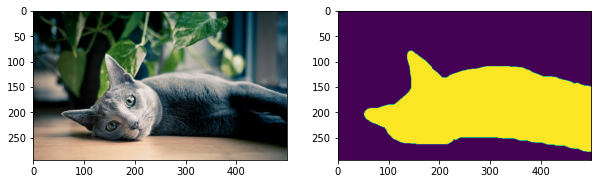

In [ ]:
# 임의의 image를 가져와서, seg map 확인
fnames = os.listdir(val_dir)
rnd_idx = random.randint(0, len(fnames)-1)
fname = fnames[rnd_idx]

fpath = os.path.join(val_dir, fname)
img = Image.open(fpath)
img = np.array(img)

## segmentation label
## 원래 label은 1: foreground, 2: background, 3: not classified 로 구성됨
## 이것을 0: background, 1 : foreground & not classified로 변경
sname = os.path.splitext(fname)[0] + '.png'
spath = os.path.join(seg_dir, sname)    
seg = Image.open(spath)
seg = np.array(seg)
seg[seg>2] = 1
seg[seg==2] = 0

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.imshow(seg)
plt.show()

## TFRecord 만들기

In [ ]:
IMG_SIZE = 224
N_TRAIN = len(train_images)
N_VAL = len(val_images)

In [ ]:
## TFRecord 저장할 directory와 file 경로 설정
tfr_dir = os.path.join(data_dir, 'tfrecord')
os.makedirs(tfr_dir, exist_ok=True)

tfr_train_dir = os.path.join(tfr_dir, 'seg_train.tfr')
tfr_val_dir = os.path.join(tfr_dir, 'seg_val.tfr')

In [ ]:
## TFRecord writer 생성
writer_train = tf.io.TFRecordWriter(tfr_train_dir)
writer_val = tf.io.TFRecordWriter(tfr_val_dir)

In [ ]:
# The following functions can be used to convert a value to a type compatible
# with tf.Example.

def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [ ]:
n_train = 0

train_files = os.listdir(train_dir)
for train_file in train_files:
  train_path = os.path.join(train_dir, train_file)
  image = Image.open(train_path)
  image = image.resize((IMG_SIZE, IMG_SIZE))
  bimage = image.tobytes()

  file_name = os.path.splitext(train_file)[0] #Bangal_101
  class_name = re.sub('_\d+', '', file_name)
  class_num = class2idx[class_name]

  if file_name[0].islower(): # dog
    bi_cls_num = 0
  else: # cat
    bi_cls_num = 1

  seg_name = file_name + '.png'
  seg_path = os.path.join(seg_dir, seg_name)
  seg = Image.open(seg_path)
  seg = seg.resize((IMG_SIZE, IMG_SIZE))
  seg = np.array(seg)
  seg[seg>2] = 1
  seg[seg==2] = 0
  bseg = seg.tobytes()

  example = tf.train.Example(features=tf.train.Features(feature={
      'image': _bytes_feature(bimage),
      'cls_num': _int64_feature(class_num),
      'bi_cls_num': _int64_feature(class_num),
      'seg': _bytes_feature(bseg)
  }))
  writer_train.write(example.SerializeToString())
  n_train += 1

writer_train.close()
print(n_train)

5920


In [ ]:
n_val = 0

val_files = os.listdir(val_dir)
for val_file in val_files:
  val_path = os.path.join(val_dir, val_file)
  image = Image.open(val_path)
  image = image.resize((IMG_SIZE, IMG_SIZE))
  bimage = image.tobytes()

  file_name = os.path.splitext(val_file)[0] #Bangal_101
  class_name = re.sub('_\d+', '', file_name)
  class_num = class2idx[class_name]

  if file_name[0].islower(): # dog
    bi_cls_num = 0
  else: # cat
    bi_cls_num = 1

  seg_name = file_name + '.png'
  seg_path = os.path.join(seg_dir, seg_name)
  seg = Image.open(seg_path)
  seg = seg.resize((IMG_SIZE, IMG_SIZE))
  seg = np.array(seg)
  seg[seg>2] = 1
  seg[seg==2] = 0
  bseg = seg.tobytes()

  example = tf.train.Example(features=tf.train.Features(feature={
      'image': _bytes_feature(bimage),
      'cls_num': _int64_feature(class_num),
      'bi_cls_num': _int64_feature(class_num),
      'seg': _bytes_feature(bseg)
  }))
  writer_val.write(example.SerializeToString())
  n_val += 1

writer_val.close()
print(n_val)

1458


## Segmentation

In [ ]:
## Hyper Parameters
N_CLASS = len(class_list)
N_EPOCHS = 20
N_BATCH = 40
IMG_SIZE = 224
learning_rate = 0.0001
steps_per_epoch = N_TRAIN / N_BATCH
validation_steps = int(np.ceil(N_VAL / N_BATCH))

In [ ]:
## tfrecord file을 data로 parsing해주는 function
def _parse_function(tfrecord_serialized):
    features={'image': tf.io.FixedLenFeature([], tf.string),
              'cls_num': tf.io.FixedLenFeature([], tf.int64),
              'bi_cls_num': tf.io.FixedLenFeature([], tf.int64),
              'seg': tf.io.FixedLenFeature([], tf.string)              
             }
    parsed_features = tf.io.parse_single_example(tfrecord_serialized, features)
    
    image = tf.io.decode_raw(parsed_features['image'], tf.uint8)    
    image = tf.reshape(image, [IMG_SIZE, IMG_SIZE, 3])
    image = tf.cast(image, tf.float32)/255.

    cls_label = tf.cast(parsed_features['cls_num'], tf.int64)
    bi_cls_label = tf.cast(parsed_features['bi_cls_num'], tf.int64)
    
    seg = tf.io.decode_raw(parsed_features['seg'], tf.uint8)    
    seg = tf.reshape(seg, [IMG_SIZE, IMG_SIZE, -1])
    seg = tf.cast(seg, tf.float32)
    
    return image, seg

In [ ]:
## train dataset 만들기
train_dataset = tf.data.TFRecordDataset(tfr_train_dir)
train_dataset = train_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=N_TRAIN).prefetch(
    tf.data.experimental.AUTOTUNE).batch(N_BATCH).repeat()

In [ ]:
## validation dataset 만들기
val_dataset = tf.data.TFRecordDataset(tfr_val_dir)
val_dataset = val_dataset.map(_parse_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(N_BATCH).repeat()

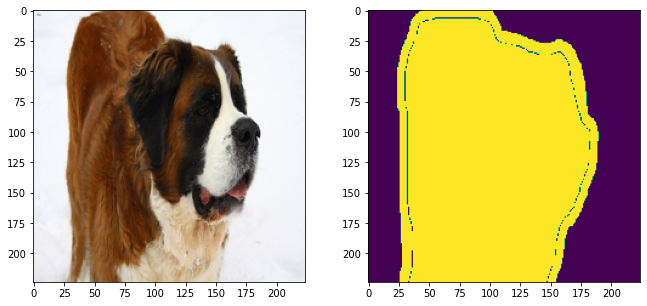

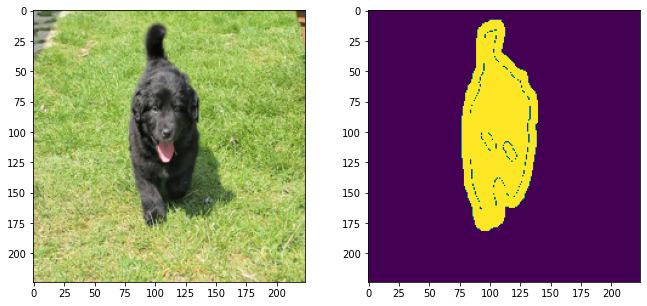

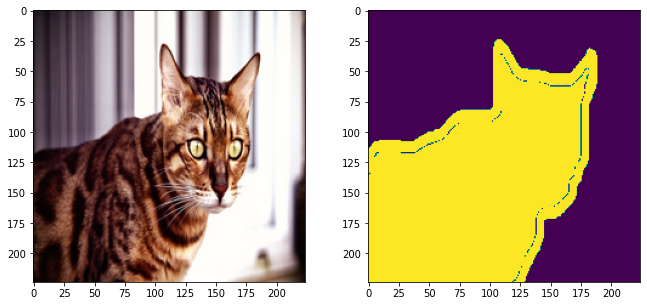

In [ ]:
## train dataset에서 1개의 image와 bbox를 읽어서 확인
for image, seg in val_dataset.take(3):
  plt.figure(figsize=(11,5))
  plt.subplot(1,2,1)
  plt.imshow(image[0])
  plt.subplot(1,2,2)
  plt.imshow(seg[0,:,:,0])
  plt.show()   

## U-Net like model에 pretrained VGG를 활용하여 학습하기

In [ ]:
from tensorflow.keras.utils import get_file

In [ ]:
## vgg16 pretrained weights 다운로드
weight_path = get_file('vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5',
                      'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')

58892288/58889256 [==============================] - 2s 0us/step


In [ ]:
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, ReLU, MaxPooling2D, Dense, BatchNormalization, GlobalAveragePooling2D, Concatenate

In [ ]:
def create_model():
    inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    
    conv1_1 = Conv2D(64, 3, 1, 'SAME', activation='relu')(inputs)
    conv1_2 = Conv2D(64, 3, 1, 'SAME', activation='relu')(conv1_1)
    pool1_3 = MaxPooling2D()(conv1_2)
    
    conv2_1 = Conv2D(128, 3, 1, 'SAME', activation='relu')(pool1_3)
    conv2_2 = Conv2D(128, 3, 1, 'SAME', activation='relu')(conv2_1)
    pool2_3 = MaxPooling2D()(conv2_2)
    
    conv3_1 = Conv2D(256, 3, 1, 'SAME', activation='relu')(pool2_3)
    conv3_2 = Conv2D(256, 3, 1, 'SAME', activation='relu')(conv3_1)
    conv3_3 = Conv2D(256, 3, 1, 'SAME', activation='relu')(conv3_2)
    pool3_4 = MaxPooling2D()(conv3_3)
    
    conv4_1 = Conv2D(512, 3, 1, 'SAME', activation='relu')(pool3_4)
    conv4_2 = Conv2D(512, 3, 1, 'SAME', activation='relu')(conv4_1)
    conv4_3 = Conv2D(512, 3, 1, 'SAME', activation='relu')(conv4_2)
    pool4_4 = MaxPooling2D()(conv4_3)
    
    conv5_1 = Conv2D(512, 3, 1, 'SAME', activation='relu')(pool4_4)
    conv5_2 = Conv2D(512, 3, 1, 'SAME', activation='relu')(conv5_1)
    conv5_3 = Conv2D(512, 3, 1, 'SAME', activation='relu')(conv5_2)
    pool5_4 = MaxPooling2D()(conv5_3)
    
    ## loading vgg16 pretrained weights
    vgg = keras.Model(inputs, pool5_4)
    vgg.load_weights(weight_path)
    
    upconv6 = Conv2DTranspose(512, 5, 2, 'SAME', activation='relu')(pool5_4)
    concat6 = Concatenate()([conv5_3, upconv6])
    conv6 = Conv2D(512, 3, 1, 'SAME', activation='relu')(concat6)
                              
    upconv7 = Conv2DTranspose(512, 5, 2, 'SAME', activation='relu')(conv6)
    concat7 = Concatenate()([conv4_3, upconv7])
    conv7 = Conv2D(512, 3, 1, 'SAME', activation='relu')(concat7)
    
    upconv8 = Conv2DTranspose(256, 5, 2, 'SAME', activation='relu')(conv7)
    concat8 = Concatenate()([conv3_3, upconv8])
    conv8 = Conv2D(256, 3, 1, 'SAME', activation='relu')(concat8)
    
    upconv9 = Conv2DTranspose(128, 5, 2, 'SAME', activation='relu')(conv8)
    concat9 = Concatenate()([conv2_2, upconv9])
    conv9 = Conv2D(128, 3, 1, 'SAME', activation='relu')(concat9)
    
    upconv10 = Conv2DTranspose(64, 5, 2, 'SAME', activation='relu')(conv9)
    concat10 = Concatenate()([conv1_2, upconv10])
    conv10 = Conv2D(64, 3, 1, 'SAME', activation='relu')(concat10)
    
    conv11 = Conv2D(64, 3, 1, 'SAME', activation='relu')(conv10)
    
    conv12 = Conv2D(2, 1, 1, 'SAME', activation='softmax')(conv11)
    
    return keras.Model(inputs=inputs, outputs=conv12) 

In [ ]:
model = create_model()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 112, 112, 64) 0           conv2d_1[0][0]                   
____________________________________________________________________________________________

In [ ]:
## learning rate scheduing
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate,
                                                          decay_steps=steps_per_epoch*10,
                                                          decay_rate=0.4,
                                                          staircase=True)
## optimizer는 Adam, loss는 sparse categorical crossentropy 사용
## label이 ont-hot으로 encoding 안 된 경우에 sparse categorical corssentropy 및 sparse categorical accuracy 사용
model.compile(keras.optimizers.Adam(lr_schedule), loss='sparse_categorical_crossentropy',
             metrics=['sparse_categorical_accuracy'])

In [ ]:
## Train!
model.fit(train_dataset, steps_per_epoch=steps_per_epoch,
         epochs=N_EPOCHS,
         validation_data=val_dataset,
         validation_steps=validation_steps)

Epoch 1/20
148/148 [==============================] - 162s 1s/step - loss: 0.3321 - sparse_categorical_accuracy: 0.8507 - val_loss: 0.1741 - val_sparse_categorical_accuracy: 0.9326
Epoch 2/20
148/148 [==============================] - 160s 1s/step - loss: 0.1665 - sparse_categorical_accuracy: 0.9371 - val_loss: 0.1568 - val_sparse_categorical_accuracy: 0.9407
Epoch 3/20
148/148 [==============================] - 160s 1s/step - loss: 0.1460 - sparse_categorical_accuracy: 0.9460 - val_loss: 0.1356 - val_sparse_categorical_accuracy: 0.9514
Epoch 4/20
148/148 [==============================] - 160s 1s/step - loss: 0.1264 - sparse_categorical_accuracy: 0.9531 - val_loss: 0.1296 - val_sparse_categorical_accuracy: 0.9522
Epoch 5/20
148/148 [==============================] - 160s 1s/step - loss: 0.1153 - sparse_categorical_accuracy: 0.9573 - val_loss: 0.1479 - val_sparse_categorical_accuracy: 0.9468
Epoch 6/20
148/148 [==============================] - 160s 1s/step - loss: 0.1082 - sparse_cate

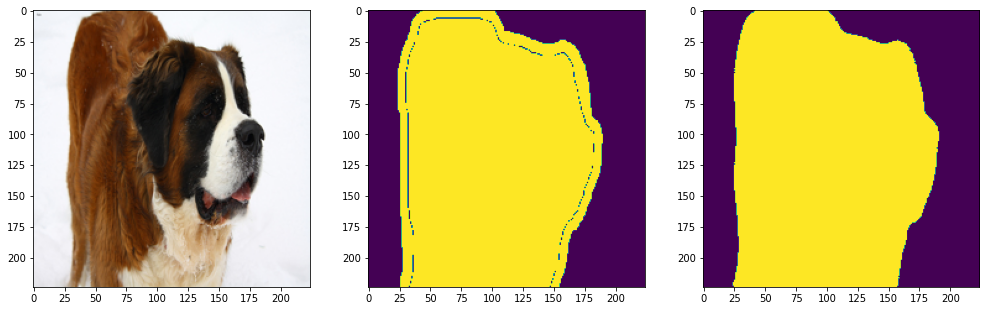

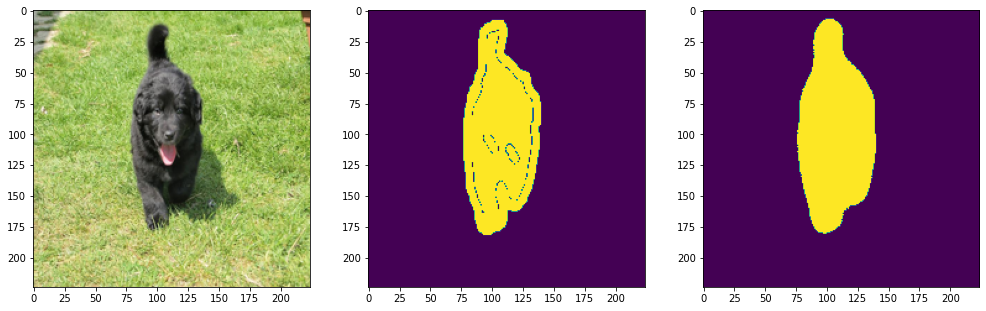

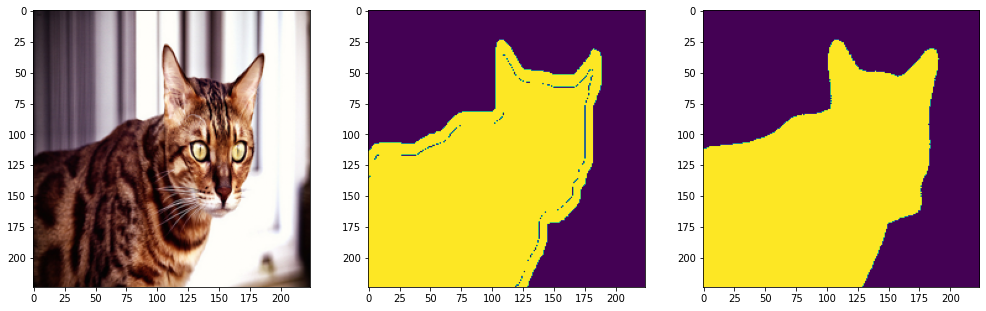

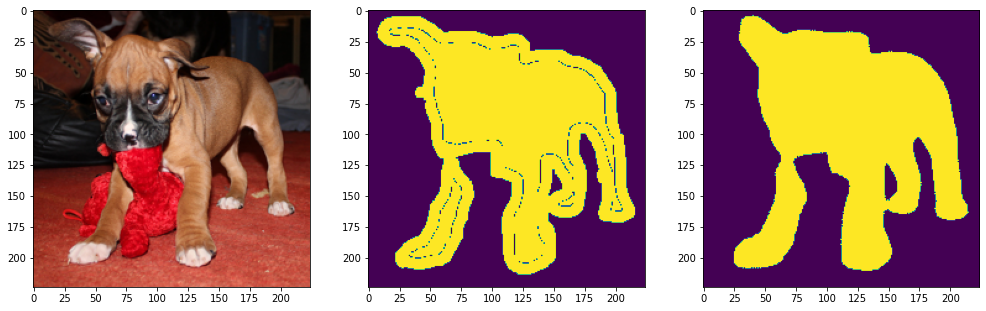

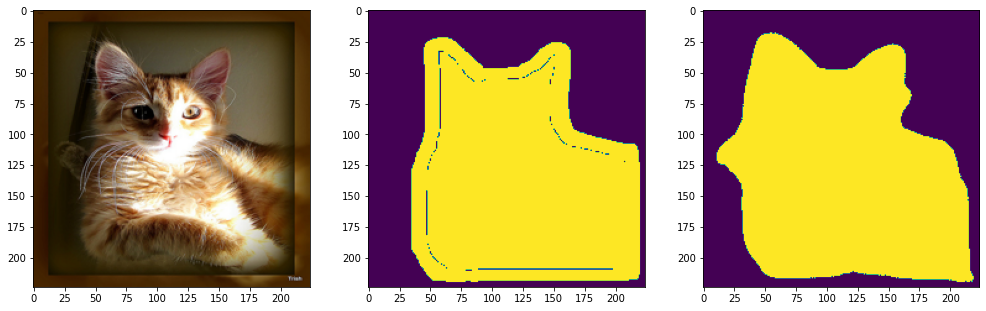

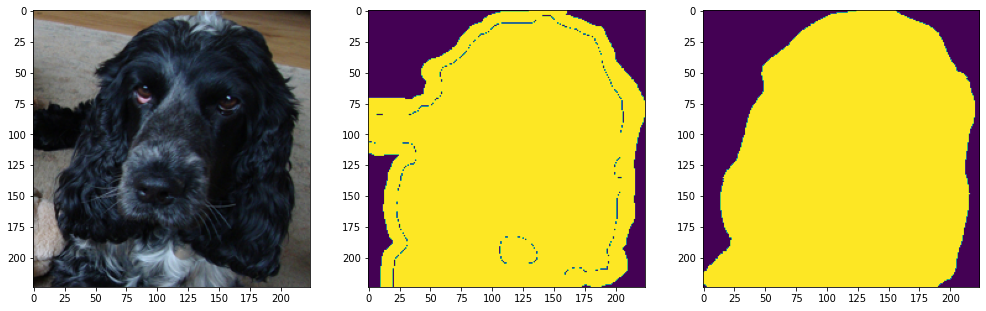

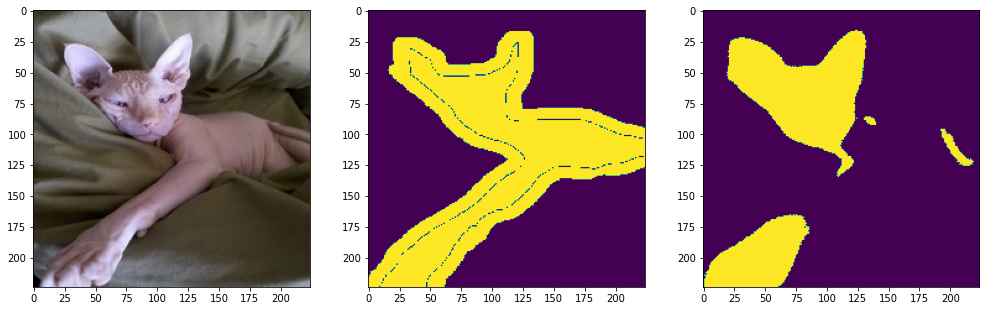

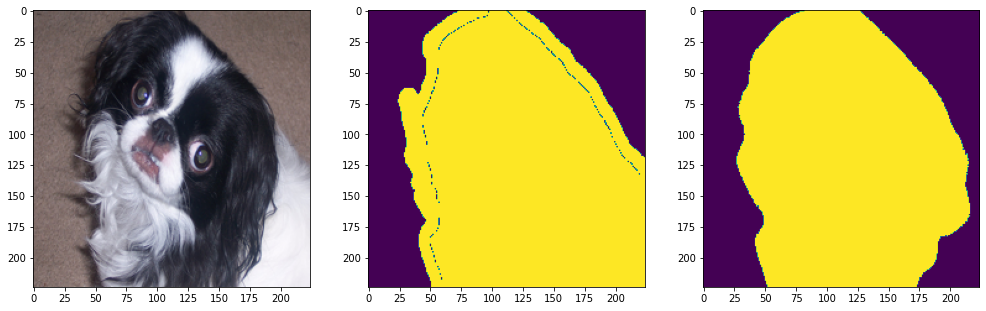

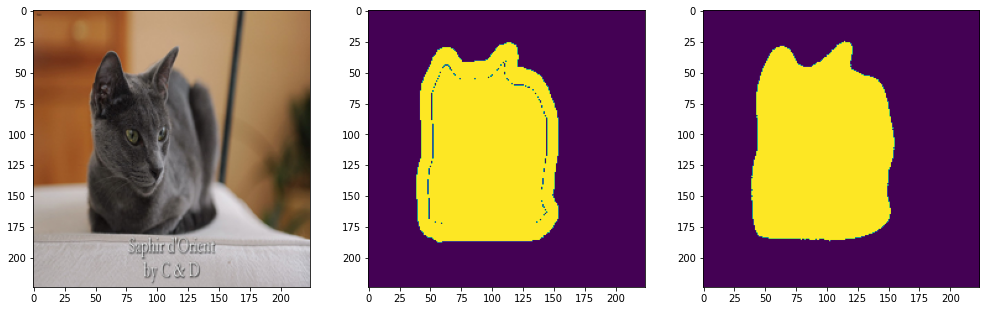

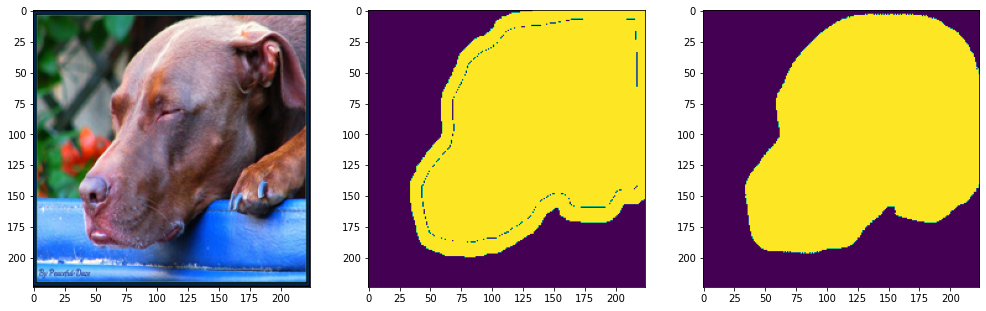

In [ ]:
## num_imgs만큼 validation dataset에서 읽어서 정답과 예측값 확인
num_imgs = 10
idx = 0
for image, seg in val_dataset.take(num_imgs):
    plt.figure(figsize=(17, 6*num_imgs))
    plt.subplot(num_imgs,3,idx*3+1)
    plt.imshow(image[0])
    plt.subplot(num_imgs,3,idx*3+2)
    plt.imshow(seg[0,:,:,0], vmin=0, vmax=1)

    plt.subplot(num_imgs,3,idx*3+3)
    ## validation data에 대한 예측값 생성
    prediction = model.predict(image)    
    pred = np.zeros_like(prediction)
    ## 0.5이상은 1로 나머지는 0으로 변환
    thr = 0.5
    pred[prediction>=thr] = 1
    pred[prediction<thr] = 0
    plt.imshow(pred[0,:,:,1])
    plt.show() 
    idx += 1

In [ ]:
## IOU 계산
avg_iou = 0
n = 0
for images, labels in val_dataset.take(validation_steps):  
  preds = model.predict(images)
  preds[preds>=0.5] = 1
  preds[preds<0.5] = 0

  psum = labels[...,0] + preds[...,1]

  union = np.array(psum)
  union[union>1] = 1.
  union = np.sum(union, axis=1)
  union = np.sum(union, axis=1)

  inter = np.array(psum)
  inter[inter==1] = 0.
  inter[inter>1] = 1.  
  inter = np.sum(inter, axis=1)
  inter = np.sum(inter, axis=1)
  
  iou = inter / union  
  avg_iou += np.sum(iou) / N_VAL

print(avg_iou)

0.8976675747843925


## 새로운 Image로 Test하기

In [ ]:
## Image upload 후 실행
image = Image.open('xxx.jpg')
image = image.resize((224, 224))
image = np.array(image)
image = image/255.

FileNotFoundError: ignored

In [ ]:
plt.imshow(image)
plt.show()

In [ ]:
image = np.reshape(image, (1, 224, 224, 3))

In [ ]:
prediction = model.predict(image)
prediction.shape

In [ ]:
pred = np.zeros_like(prediction)
## 0.5이상은 1로 나머지는 0으로 변환
thr = 0.5
pred[prediction>=thr] = 1
pred[prediction<thr] = 0

In [ ]:
## 예측 결과 확인
plt.figure(figsize=(11,5))
plt.subplot(1,2,1)
plt.imshow(image[0])
plt.subplot(1,2,2)
plt.imshow(pred[0,:,:,1])
plt.show()  